# Giai đoạn 1 – SSIM 2 lớp

In [1]:
import cv2, os, re
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def load_cases():
    mapping = {'identical':'similar', 'text_changes':'different', 'layout_changes':'different',
               'changes':'different', 'completely_different':'different'}
    cases = []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"
    
    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m: continue
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir): continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label:
                cases.append((os.path.join(ori_dir, f), os.path.join(vidir, vf), label))
    return cases

class Ver_1_SVM:
    def __init__(self, C=1.0, kernel='linear'):
        self.scaler = StandardScaler()
        self.model = SVC(
            kernel=kernel, 
            C=C, 
            class_weight='balanced'
        ) 
        self.map = {'similar':0, 'different':1}
        self.names = ['Similar', 'Different']

    def prep_gray(self, img):
        g = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels = 700_000  
        h, w = g.shape
        if h * w > max_pixels:
            s = (max_pixels / (h * w)) ** 0.5
            g = cv2.resize(g, (int(w * s), int(h * s)))
        g = cv2.medianBlur(g, 3)
        return g

    def ssim(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            return ssim(g1, g2, data_range=255)
        except:
            return 0.5

    def feat(self, a, b):
        return [self.ssim(a, b)]

    def train_eval(self, cases):
        X = [self.feat(a, b) for a, b, l in cases]
        y = [self.map[l] for _, _, l in cases]
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        self.scaler.fit(Xtr)
        self.model.fit(self.scaler.transform(Xtr), ytr)
        yp = self.model.predict(self.scaler.transform(Xte))
        print(f"Acc: {(yp == yte).mean()*100:.1f}%")
        print(classification_report(yte, yp, target_names=self.names))
        print(confusion_matrix(yte, yp))
 
cases = load_cases()
print(f"{len(cases)} cases")
Ver_1_SVM().train_eval(cases)


300 cases
Acc: 95.0%
              precision    recall  f1-score   support

     Similar       0.80      1.00      0.89        12
   Different       1.00      0.94      0.97        48

    accuracy                           0.95        60
   macro avg       0.90      0.97      0.93        60
weighted avg       0.96      0.95      0.95        60

[[12  0]
 [ 3 45]]


In [2]:
import cv2, os, re
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

def load_cases():
    mapping = {
        'identical': 'similar',
        'text_changes': 'different',
        'layout_changes': 'different',
        'changes': 'different',
        'completely_different': 'different'
    }
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"
    
    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m:
            continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir):
            continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label:
                cases.append((os.path.join(ori_dir, f), os.path.join(vidir, vf), label))
                groups.append(group_id)
    return cases, groups

class Ver_1_SVM:
    def __init__(self, C=1.0, kernel='linear'):  
        self.scaler = StandardScaler()
        self.model = SVC(
            kernel=kernel,
            C=C,        
            class_weight='balanced',
            random_state=42
        )
        self.map = {'similar': 0, 'different': 1}
        self.names = ['Similar', 'Different']

    def prep_gray(self, img):
        g = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels = 700_000
        h, w = g.shape
        if h * w > max_pixels:
            s = (max_pixels / (h * w)) ** 0.5
            g = cv2.resize(g, (int(w * s), int(h * s)))
        g = cv2.medianBlur(g, 3)
        return g
    
    def ensure_same_size(self, g1, g2):
        if g1 is None or g2 is None: return None, None
        if g1.shape == g2.shape: return g1, g2
        h1, w1 = g1.shape
        g2 = cv2.resize(g2, (w1, h1)) 
        return g1, g2

    def ssim(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            g1, g2 = self.ensure_same_size(g1, g2)
            if g1 is None or g2 is None: return 0.5
            return ssim(g1, g2, data_range=255)
        except: return 0.5

    def feat(self, a, b):
        return [self.ssim(a, b)]

    def train_eval_kfold(self, cases, groups, n_splits=5):
        X = [self.feat(a, b) for a, b, l in cases]
        y = [self.map[l] for _, _, l in cases]

        gkf = GroupKFold(n_splits=n_splits)
        accuracies = []
        fold_num = 1

        for train_idx, test_idx in gkf.split(X, y, groups):
            print(f"\n===== Fold {fold_num} =====")
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]

            self.scaler.fit(Xtr)
            self.model.fit(self.scaler.transform(Xtr), ytr)
            yp = self.model.predict(self.scaler.transform(Xte))

            acc = (yp == yte).mean() * 100
            accuracies.append(acc)

            print(f"Accuracy: {acc:.1f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold_num += 1

        print(f"Mean Accuracy: {np.mean(accuracies):.1f}%")
        print(f"Std Accuracy: {np.std(accuracies):.1f}%")
        
        return np.mean(accuracies), np.std(accuracies)

cases, groups = load_cases()
print(f"{len(cases)} cases from {len(set(groups))} groups")
v1_model = Ver_1_SVM() 
v1_mean, v1_std = v1_model.train_eval_kfold(cases, groups, n_splits=5)

300 cases from 60 groups

===== Fold 1 =====
Accuracy: 91.7%
              precision    recall  f1-score   support

     Similar       0.71      1.00      0.83        12
   Different       1.00      0.90      0.95        48

    accuracy                           0.92        60
   macro avg       0.85      0.95      0.89        60
weighted avg       0.94      0.92      0.92        60

[[12  0]
 [ 5 43]]

===== Fold 2 =====
Accuracy: 93.3%
              precision    recall  f1-score   support

     Similar       0.75      1.00      0.86        12
   Different       1.00      0.92      0.96        48

    accuracy                           0.93        60
   macro avg       0.88      0.96      0.91        60
weighted avg       0.95      0.93      0.94        60

[[12  0]
 [ 4 44]]

===== Fold 3 =====
Accuracy: 91.7%
              precision    recall  f1-score   support

     Similar       0.71      1.00      0.83        12
   Different       1.00      0.90      0.95        48

    accurac

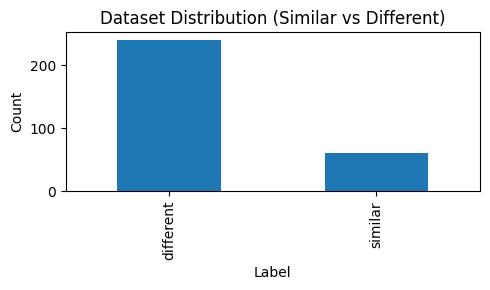

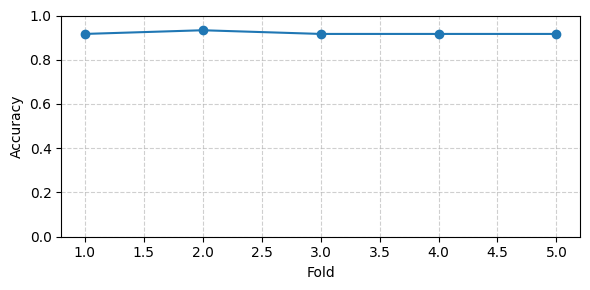

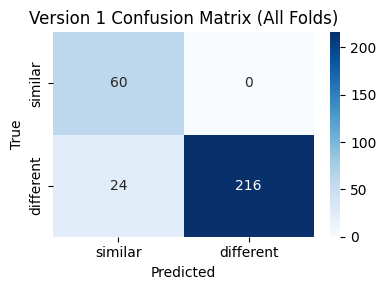

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score

def build_feature_df(feat_extractor, cases, groups):
    rows = []
    for (a,b,l), g in zip(cases, groups):
        f = feat_extractor.feat(a,b)
        cols = ['SSIM','OCR','Hist','ORB','Layout'] if len(f)==5 else \
               ['SSIM','OCR','Hist','Layout'] if len(f)==4 else \
               ['SSIM','Hist','Layout'] if len(f)==3 else ['SSIM']
        row = {c:v for c,v in zip(cols,f)}
        row['label'] = l
        row['group'] = g
        rows.append(row)
    return pd.DataFrame(rows)

df_v1 = build_feature_df(v1_model, [(a,b,l) for a,b,l in cases], groups)

plt.figure(figsize=(5,3))
df_v1['label'].value_counts().plot(kind='bar')
plt.title("Dataset Distribution (Similar vs Different)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

gkf = GroupKFold(n_splits=5)
accs = []
all_true, all_pred = [], []

for train_idx, test_idx in gkf.split(df_v1, df_v1['label'], groups):
    X_train, X_test = df_v1.iloc[train_idx][['SSIM']], df_v1.iloc[test_idx][['SSIM']]
    y_train, y_test = df_v1.iloc[train_idx]['label'], df_v1.iloc[test_idx]['label']
    v1_model.scaler.fit(X_train)
    v1_model.model.fit(v1_model.scaler.transform(X_train),
                    [v1_model.map[l] for l in y_train])
    preds_int = v1_model.model.predict(v1_model.scaler.transform(X_test))
    inv_map = {v:k for k,v in v1_model.map.items()}
    preds = [inv_map[i] for i in preds_int]
    accs.append(accuracy_score(y_test, preds))
    all_true.extend(y_test)
    all_pred.extend(preds)

plt.figure(figsize=(6,3))
plt.plot(range(1,6), accs, marker='o')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_pred, labels=['similar','different'])

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['similar','different'],
            yticklabels=['similar','different'])
plt.title("Version 1 Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()